Extracting and quantifying chromatin patterns from routine Hematoxylin and Eosin (H&E) stained images offers important insights into nuclear architecture, an important indicator of cellular state that undergoes profound alterations in various disease pathologies, particularly cancer. This analysis workflow provides an example of how Histolytics can be used to extract and quantify chromatin patterns from H&E stained images, focusing on the following key steps:

- Segmentation of individual chromatin clumps within cell nuclei.
- Computation of key quantitative features, such as chromatin clump area and the proportion of chromatin clump area to the total nuclear area.

These interpretable metrics of chromatin organization can reveal significant biological insights; for example, a low chromatin clump-to-nucleus area ratio might indicate dispersed chromatin, while a higher proportion can reflect increased chromatin condensation or hyperchromatism—hallmarks often associated with malignancy.

Let's start the workflow demonstration by loading the example data:

<Axes: >

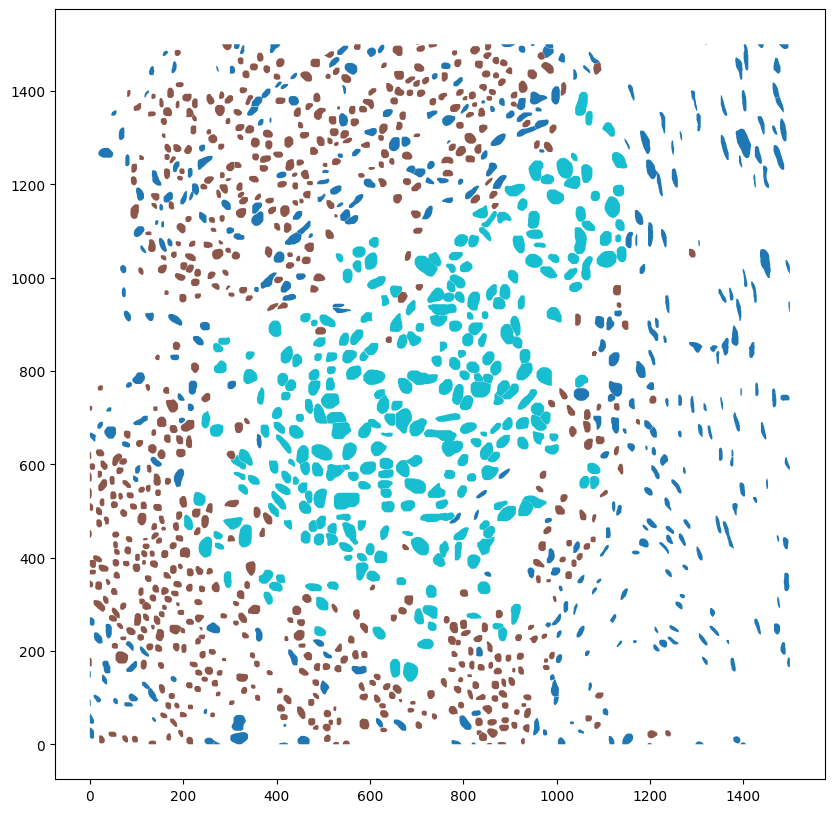

In [1]:
from histolytics.data import hgsc_cancer_he, hgsc_cancer_nuclei

he = hgsc_cancer_he()
nuc = hgsc_cancer_nuclei()

nuc.plot(figsize=(10, 10), column="class_name")

## Convert vector data to raster format

First, we will need to convert the vector data of nuclei to raster format. This is because we are working with dense rgb-image data, meaning that the nuclei masks need to be in also in dense raster-format. The conversion allows us to be able to point to the nuclear regions within the image and focus the segmentation analysis within those regions. The conversion can be done using the `gdf2inst` and `gdf2sem` functions from the histolytics package.

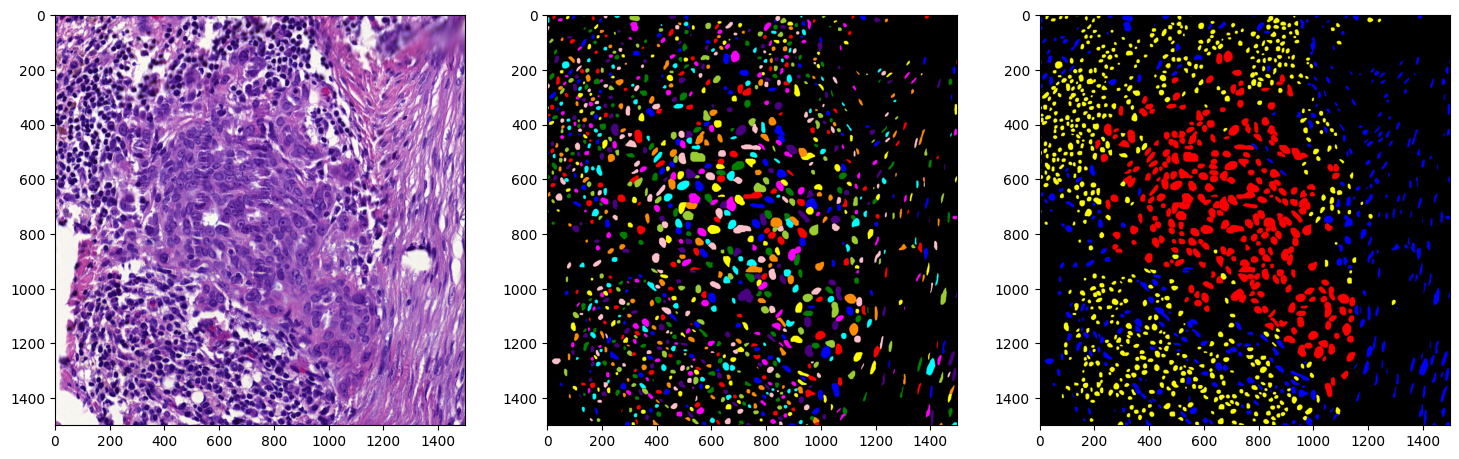

In [2]:
from histolytics.utils.raster import gdf2inst, gdf2sem
import matplotlib.pyplot as plt
from skimage.color import label2rgb


cls_dict = {
    "neoplastic": 1,
    "connective": 2,
    "inflammatory": 3,
}

# convert the nuclei gdf into raster mask
inst_mask = gdf2inst(nuc, width=he.shape[1], height=he.shape[0])
type_mask = gdf2sem(nuc, class_dict=cls_dict, width=he.shape[1], height=he.shape[0])

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(he)
ax[1].imshow(label2rgb(inst_mask, bg_label=0, alpha=0.5))
ax[2].imshow(label2rgb(type_mask, bg_label=0, alpha=0.5))
plt.show()

## Chromatin clump segmentation

Next, we will segment the chromatin clumps from the nuclei. This can be done using the `chromatin_feats` function. It takes the rasterized nuclei mask and the rgb image as input, and returns a list of segmented chromatin clumps, chromatin clump area per nuclei, and the chromatin-to-nuclei (area) proportion per nuclei. We will segment the chromatins for only the neoplastic nuclei in this example.

In [3]:
import numpy as np
from histolytics.nuc_feats.chromatin import chromatin_feats

neo_mask = inst_mask.copy()
neo_mask[type_mask != cls_dict["neoplastic"]] = 0

chrom_mask, chrom_areas, chrom_nuc_props = chromatin_feats(he, neo_mask)

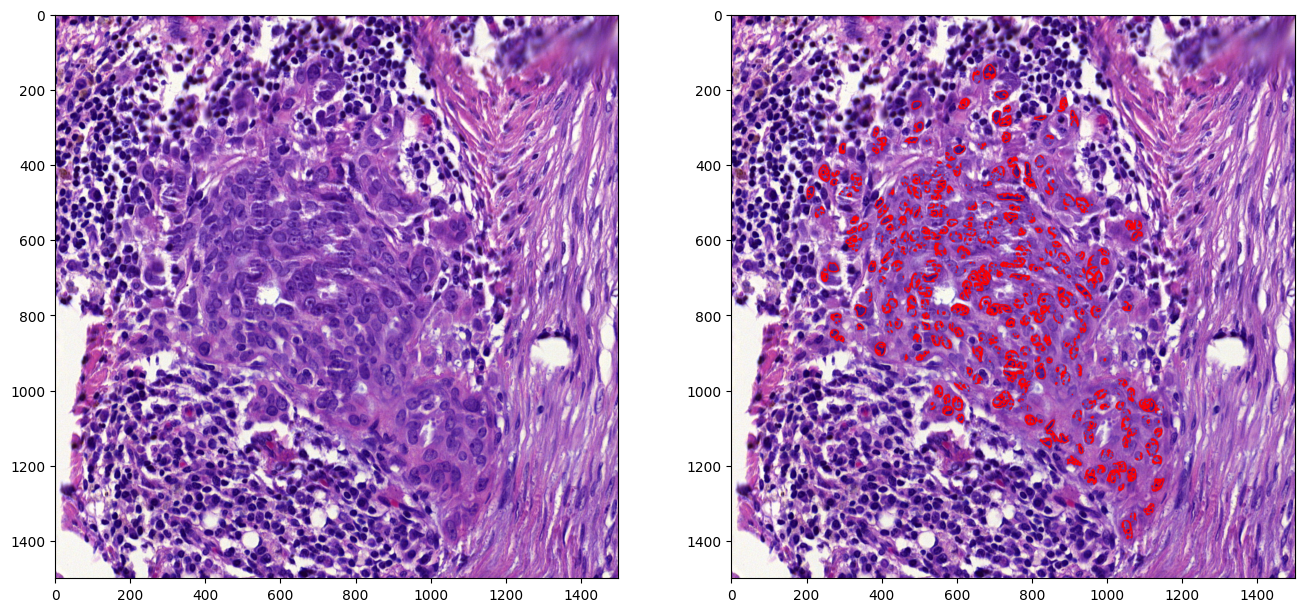

In [4]:
from histolytics.utils.plot import draw_thing_contours
from skimage.measure import label


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

contours = draw_thing_contours(he, label(chrom_mask), chrom_mask)
ax[0].imshow(he)
ax[1].imshow(contours)

Let's take a bit of a closer look at the segmented chromatin clumps.

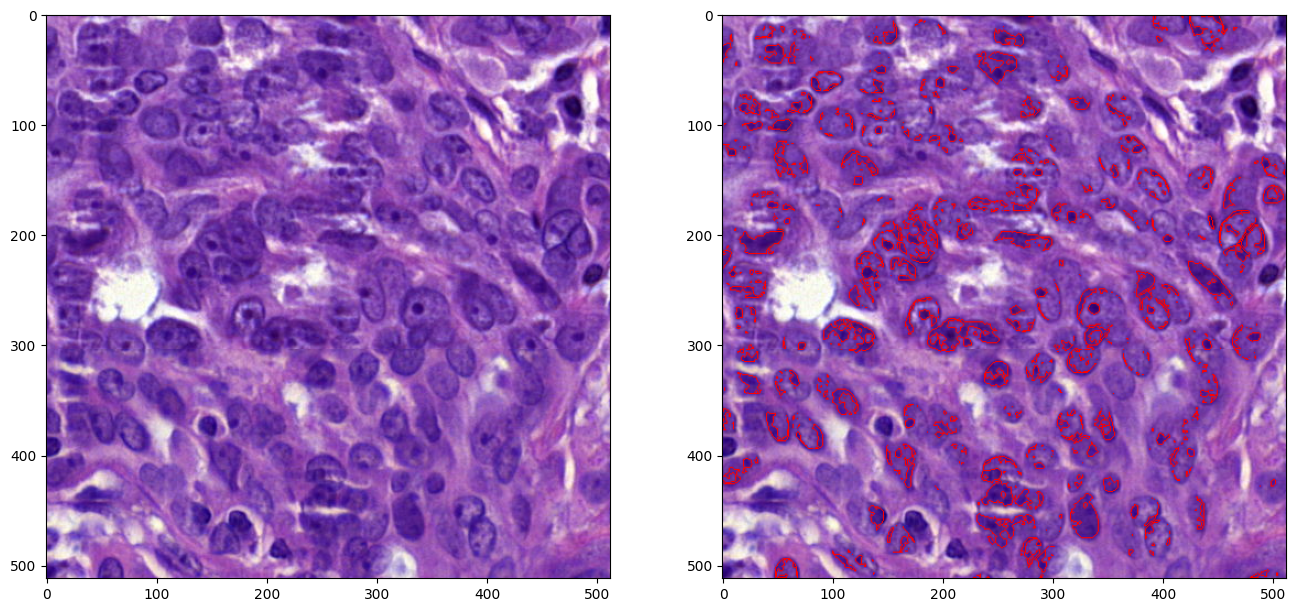

In [5]:
from histolytics.utils.plot import draw_thing_contours
from skimage.measure import label


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Take a center crop of size 512x512 from chrom_mask and he for zoomed-in illustration
h, w = chrom_mask.shape
crop_size = 512
start_y = (h - crop_size) // 2
start_x = (w - crop_size) // 2

chrom_mask_crop = chrom_mask[
    start_y : start_y + crop_size, start_x : start_x + crop_size
]
he_crop = he[start_y : start_y + crop_size, start_x : start_x + crop_size]

contours = draw_thing_contours(
    he_crop, label(chrom_mask_crop), chrom_mask_crop, thickness=1
)
ax[0].imshow(he_crop)
ax[1].imshow(contours)

The results look reasonable by eyeballing. If you feel like you want to convert the chromatin masks into a geodataframe you can do it in the following way:

In [6]:
from histolytics.utils.raster import inst2gdf

inst2gdf(
    label(chrom_mask).astype(np.int32),
    chrom_mask.astype(np.int32),
    class_dict={1: "chromatin"},
    min_size=3,
)

,uid,class_name,geometry
0,1,chromatin,"POLYGON ((683.5 134.6, 683.2 134.9, 682.8 135...."
1,3,chromatin,"POLYGON ((653.8 151.8, 653.8 152.2, 653.6 152...."
2,5,chromatin,"POLYGON ((718.1 204.6, 717 204.9, 715.5 205.2,..."
3,8,chromatin,"POLYGON ((609.4 236.2, 609.6 236.2, 609.6 236...."
4,13,chromatin,"POLYGON ((732.7 243.6, 732.8 243.6, 732.8 243...."
...,...,...,...
821,1113,chromatin,"POLYGON ((1044.8 1370, 1044.8 1370.8, 1044.9 1..."
822,1114,chromatin,"POLYGON ((1055.2 1370.6, 1054.8 1370.9, 1054.3..."
823,1116,chromatin,"POLYGON ((1048.4 1379.8, 1048.6 1379.9, 1048.7..."
824,1115,chromatin,"POLYGON ((1065.5 1377.2, 1065.2 1377.9, 1065.1..."


Or alternatively, you can just add the computed chromatin features to the existing geodataframe:

In [7]:
nuc.loc[nuc["class_name"] == "neoplastic", "chromatin_clump_area"] = chrom_areas
nuc.loc[nuc["class_name"] == "neoplastic", "chromatin_nucleus_proportion"] = (
    chrom_nuc_props
)
nuc

,geometry,class_name,chromatin_clump_area,chromatin_nucleus_proportion
0,"POLYGON ((1394.01 0, 1395.01 1.99, 1398 3.99, ...",connective,NaN,NaN
1,"POLYGON ((1391 2.01, 1387 2.01, 1384.01 3.01, ...",connective,NaN,NaN
2,"POLYGON ((1382.99 156.01, 1380 156.01, 1376.01...",connective,NaN,NaN
3,"POLYGON ((1321 170.01, 1317.01 174.01, 1312.01...",connective,NaN,NaN
4,"POLYGON ((1297.01 0, 1299.01 2.99, 1302 5.99, ...",connective,NaN,NaN
...,...,...,...,...
1290,"POLYGON ((258 495, 258 496, 255 496, 255 497, ...",inflammatory,NaN,NaN
1291,"POLYGON ((855.25 359, 851 360.01, 849.01 361.0...",connective,NaN,NaN
1292,"POLYGON ((841 405, 841 406, 840 406, 840 407, ...",neoplastic,59.0,0.066143
1293,"POLYGON ((954 506, 954 507, 952 507, 952 508, ...",neoplastic,72.0,0.091487


Let's visualize which neoplastic nuclei have the highest chromatin clump area to nucleus area proportion i.e. the most chromatin-rich nuclei.

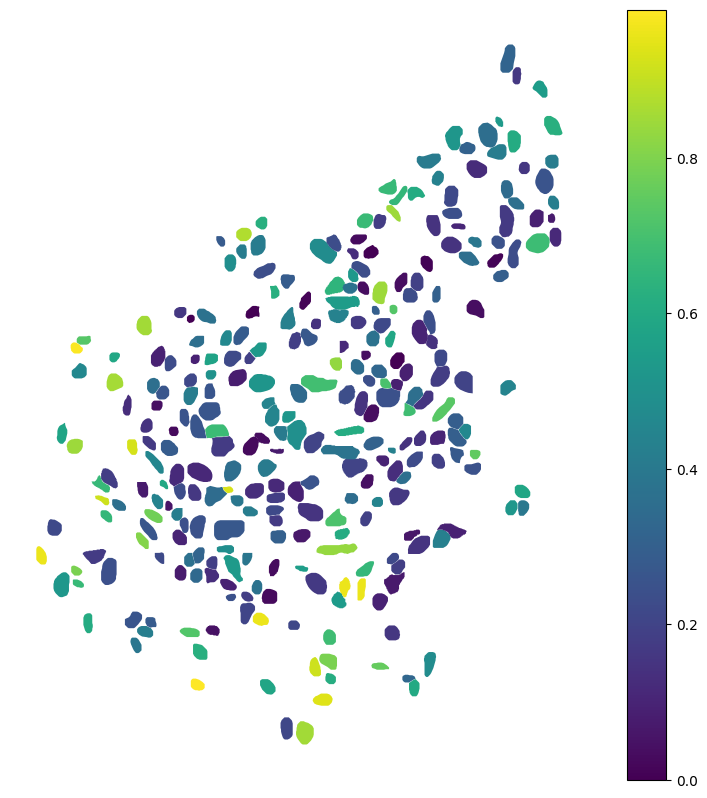

In [8]:
ax = nuc.plot(
    figsize=(10, 10),
    column="chromatin_nucleus_proportion",
    legend=True,
)
ax.set_axis_off()

Note: the gdf.plot appears upside down, this is because the origin in the raster data is in the top left corner, while in the geodataframe it is in the bottom left corner.

## Conclusion
In this workflow tutorial we have demonstrated how to extract chromatin clumps from nuclei in histological images and how to compute chromatin clump area and the proportion of chromatin clump area to the total nuclear area, and visualize the results. This type of analysis can be used to quantify chromatin organization and can provide insights into the cellular state and disease pathologies.